<a href="https://colab.research.google.com/github/momomendoza2476-max/SIMULACI-N-II/blob/main/tumorrat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Output()

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha      1.296  0.291   0.784    1.833      0.005    0.003   3301.510   
beta       7.325  1.716   4.296   10.529      0.027    0.021   4106.449   
theta[0]   0.045  0.039   0.000    0.114      0.000    0.001   7573.373   
theta[1]   0.045  0.038   0.000    0.115      0.000    0.001   8907.936   
theta[2]   0.045  0.039   0.000    0.117      0.000    0.001   8833.146   
...          ...    ...     ...      ...        ...      ...        ...   
theta[66]  0.286  0.059   0.175    0.396      0.000    0.001  18788.004   
theta[67]  0.298  0.061   0.191    0.418      0.000    0.001  14692.735   
theta[68]  0.294  0.061   0.183    0.408      0.000    0.001  17691.306   
theta[69]  0.317  0.081   0.170    0.470      0.001    0.001  17786.662   
theta[70]  0.234  0.087   0.083    0.396      0.001    0.001  16243.763   

           ess_tail  r_hat  
alpha      4942.046  1.001  
beta       5493.757  1.001  
theta[0]   4

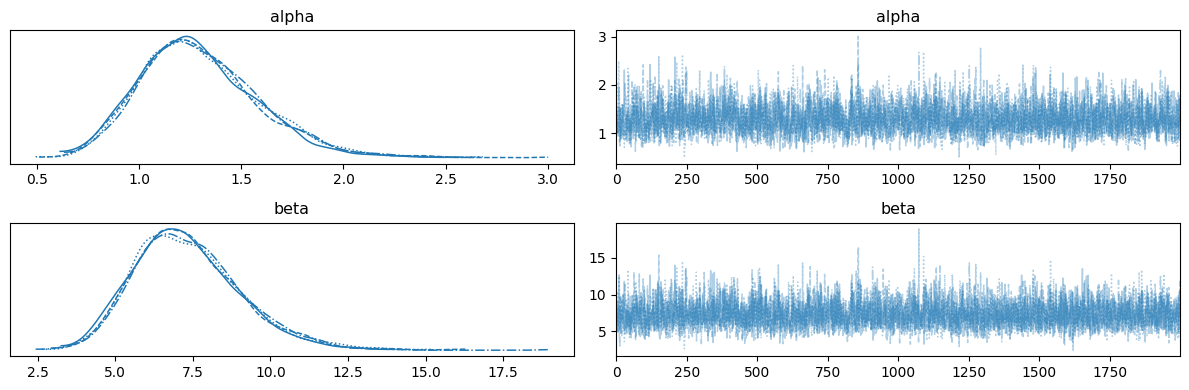

Output()

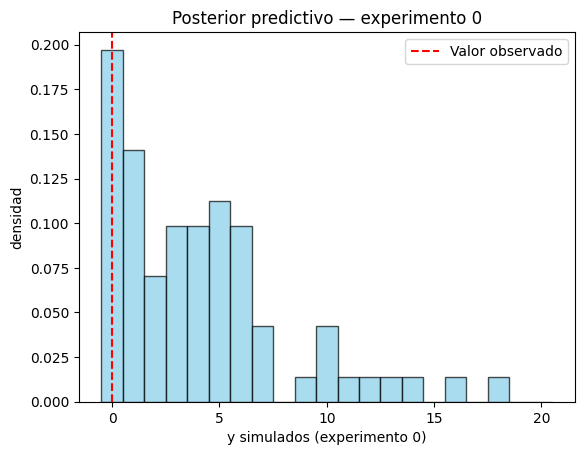

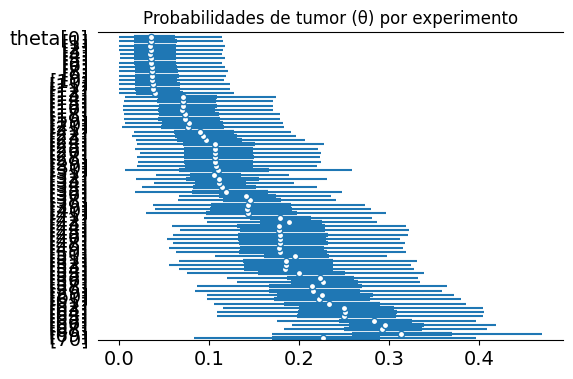


Interpretación breve:
- alpha, beta: hiperparámetros comunes que gobernarán la variabilidad entre experimentos.
- theta[i]: probabilidad posterior de que una rata tenga tumor en el experimento i.
- Posterior predictivo: cómo el modelo simula datos nuevos similares a los observados.


In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Datos reales del ejemplo Rat Tumor (71 experimentos)
# -----------------------------
y_obs = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
   10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
   15,  9,  4
], dtype=int)

n = np.array([
   20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
   20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
   46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
   48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
   47, 24, 14
], dtype=int)

J = len(n)  # será 71

# -----------------------------
# 2. Modelo jerárquico (Beta‑Binomial)
# -----------------------------
with pm.Model() as hierarchical_model:
    # Hiperpriores débiles (Exponential) para alpha y beta
    alpha = pm.Exponential("alpha", 1.0)
    beta  = pm.Exponential("beta", 1.0)

    # Nivel intermedio: probabilidades por experimento
    theta = pm.Beta("theta", alpha=alpha, beta=beta, shape=J)

    # Nivel de los datos: observaciones binomiales
    y = pm.Binomial("y", n=n, p=theta, observed=y_obs)

    # -----------------------------
    # 3. Inferencia por MCMC
    # -----------------------------
    idata = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

# -----------------------------
# 4. Resumen de los resultados
# -----------------------------
print(az.summary(idata, var_names=["alpha", "beta", "theta"], round_to=3))

# -----------------------------
# 5. Gráficas de diagnóstico
# -----------------------------
az.plot_trace(idata, var_names=["alpha", "beta"])
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Posterior predictivo
# -----------------------------
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(idata, var_names=["y"], random_seed=42)

# Ejemplo: simulaciones para el primer experimento (índice 0)
sim_y0 = ppc.posterior_predictive["y"].stack(draws=("chain", "draw")).values[:, 0]
plt.figure()
plt.hist(sim_y0, bins=range(0, n[0]+2), align='left', density=True,
         alpha=0.7, color="skyblue", edgecolor="black")
plt.axvline(y_obs[0], color="red", linestyle="--", label="Valor observado")
plt.xlabel("y simulados (experimento 0)")
plt.ylabel("densidad")
plt.title("Posterior predictivo — experimento 0")
plt.legend()
plt.show()

# -----------------------------
# 7. Posterior de theta por experimento
# -----------------------------
az.plot_forest(idata, var_names=["theta"], combined=True, figsize=(6,4))
plt.title("Probabilidades de tumor (θ) por experimento")
plt.show()

# -----------------------------
# 8. Interpretación rápida
# -----------------------------
print("\nInterpretación breve:")
print("- alpha, beta: hiperparámetros comunes que gobernarán la variabilidad entre experimentos.")
print("- theta[i]: probabilidad posterior de que una rata tenga tumor en el experimento i.")
print("- Posterior predictivo: cómo el modelo simula datos nuevos similares a los observados.")
